In [1]:
!pip install catboost

     |████████████████████████████████| 67.3MB 46kB/s 


In [1]:
import os
import shutil
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import lightgbm as lgbm
from google.colab import files
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import precision_score
import torch
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
torch.manual_seed(22)
random.seed(22)

In [4]:
files.upload(); #animals_data.zip

Saving animals_data.zip to animals_data.zip


In [3]:
data_dir = '/content/data'

In [6]:
shutil.unpack_archive('/content/animals_data.zip', data_dir)

In [4]:
df = pd.read_csv(os.path.join(data_dir, 'animals_data.csv'))
print("Строк в датасете: {}".format(len(df)))

Строк в датасете: 967


In [8]:
df.head()

,id,cat,cow,dog,horse,sheep,bounds_x,bounds_y,bounds_width,bounds_height,L_eye_v,L_eye_x,L_eye_y,R_eye_v,R_eye_x,R_eye_y,L_ear_v,L_ear_x,L_ear_y,R_ear_v,R_ear_x,R_ear_y,Nose_v,Nose_x,Nose_y,Throat_v,Throat_x,Throat_y,Tail_v,Tail_x,Tail_y,withers_v,withers_x,withers_y,L_F_elbow_v,L_F_elbow_x,L_F_elbow_y,R_F_elbow_v,R_F_elbow_x,R_F_elbow_y,L_B_elbow_v,L_B_elbow_x,L_B_elbow_y,R_B_elbow_v,R_B_elbow_x,R_B_elbow_y,L_F_knee_v,L_F_knee_x,L_F_knee_y,R_F_knee_v,R_F_knee_x,R_F_knee_y,L_B_knee_v,L_B_knee_x,L_B_knee_y,R_B_knee_v,R_B_knee_x,R_B_knee_y,L_F_paw_v,L_F_paw_x,L_F_paw_y,R_F_paw_v,R_F_paw_x,R_F_paw_y,L_B_paw_v,L_B_paw_x,L_B_paw_y,R_B_paw_v,R_B_paw_x,R_B_paw_y,stand,sit,lie,go,run
0,0,1,0,0,0,0,2,5,296,204,1,178,71,1,132,65,1,203,33,1,117,19,1,154,86,1,157,119,0,0,0,0,0,0,1,213,146,1,94,130,0,0,0,0,0,0,1,265,162,1,72,158,0,0,0,0,0,0,0,0,0,1,6,174,0,0,0,0,0,0,0,0,1,0,0
1,1,1,0,0,0,0,20,8,260,286,1,202,145,1,99,149,1,248,46,1,46,56,1,147,190,1,146,276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2,1,0,0,0,0,5,11,282,224,1,190,129,1,130,125,1,240,75,1,102,61,1,160,136,1,154,200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3,1,0,0,0,0,9,13,274,228,1,221,85,1,179,91,1,245,33,1,145,40,1,200,92,1,205,130,1,46,127,1,124,72,1,232,175,1,130,170,0,0,0,1,63,179,1,210,201,1,149,206,0,0,0,1,75,206,1,218,227,1,144,233,0,0,0,1,87,221,1,0,0,0,0
4,4,1,0,0,0,0,25,0,236,220,1,178,79,1,114,99,1,195,20,1,47,48,1,156,118,1,160,164,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [5]:
classes = ['stand', 'sit', 'lie', 'go', 'run']
X = df.drop(classes, axis=1)
y = df[['id'] + classes]

In [6]:
for column in X.columns:
    if '_x' in column or '_width' in column or '_y' in column or '_height' in column:
        X[column] = X[column].astype(float)

df_dict = X.to_dict()

for idx in df_dict['id'].values():
    img_name = os.path.join(data_dir, 'animals', "0"*(3-len(str(idx))) + str(idx) + ".jpeg")
    image = Image.open(img_name)
    x_size, y_size = image.size
    for column in df_dict.keys():
        if '_x' in column or '_width' in column:
            df_dict[column][idx] /= x_size
        elif '_y' in column or '_height' in column:
            df_dict[column][idx] /= y_size

X = pd.DataFrame.from_dict(df_dict)

In [ ]:
y['label'] = 0

# for idx in range(1, len(y.columns)-1):
#     y['label'] += y[y.columns[idx]] * (idx - 1)

y['label'] = 0
for idx in range(1, len(y.columns)-1):
    y['label'] += y[y.columns[idx]] * int(idx > 1)

In [8]:
X.set_index('id', inplace=True)
y.set_index('id', inplace=True)

In [9]:
X['animal'] = 0
for idx in range(5):
    X['animal'] += X[X.columns[idx]] * idx

X = X.drop(['cat', 'cow', 'dog', 'horse', 'sheep'], axis=1)

X['bounds_width'] += X['bounds_x']
X['bounds_height'] += X['bounds_y']

550 102 103 129 83


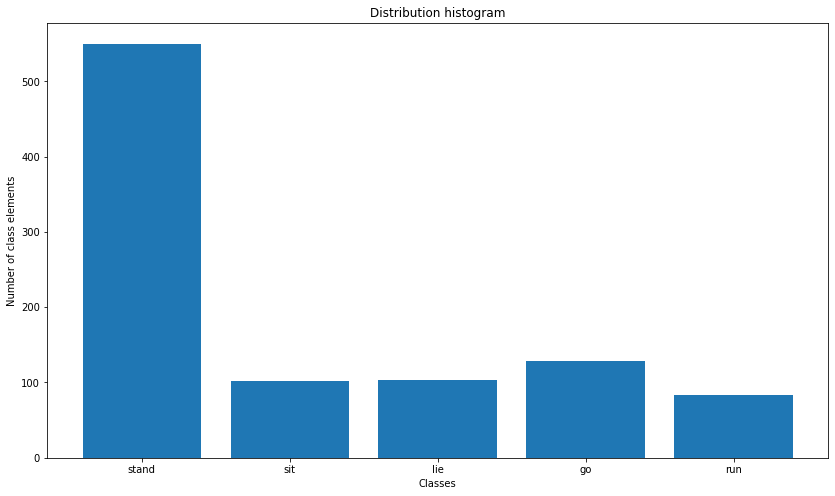

In [10]:
def distrib_hist(y):
    plt.rcParams['figure.figsize'] = (14, 8)
    levels = list(sum(list(y[col])) for col in y.columns[:-1])
    names = list(y.columns[:-1])

    plt.bar(range(len(levels)), levels);
    plt.xticks(range(len(levels)), names);
    plt.ylabel('Number of class elements')
    plt.xlabel('Classes')
    plt.title("Distribution histogram");

    print(*levels)

distrib_hist(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=22)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.4, random_state=22)

print(f"SPLIT\nTrain:\t{len(X_train)}\nVal:\t{len(X_val)}\nTest:\t{len(X_test)}")

SPLIT
Train:	580
Val:	232
Test:	155


In [16]:
coord_columns = []
for c in range(len(X_train.columns)):
    column = X_train.columns[c]
    if '_x' in column or '_width' in column or '_y' in column or '_height' in column:
        coord_columns.append(c)

delta = 0.001

next_idx = float(max(list(map(int, X_train.index))) + 1)

roof = max(list(sum(list(y_train[col])) for col in y_train.columns[:-1]))

for idx in range(len(y_train.columns)-1):
    list_index = 0
    while sum(list(y_train[y_train.columns[idx]])) != roof:
        indexes = list(map(int, X_train.index))
        features = list(X_train.loc[indexes[list_index]])
        answers = list(y_train.loc[indexes[list_index]])

        if answers[-1] == idx:
            for cc in coord_columns:
                if features[cc] != 0:
                    features[cc] += random.uniform(-delta, delta)
            X_train = X_train.append(pd.Series(features, index=X_train.columns, name=next_idx))
            y_train = y_train.append(pd.Series(answers, index=y_train.columns, name=next_idx))
            next_idx += 1
        list_index = (list_index + 1) % len(X_train)

335 57 61 71 56


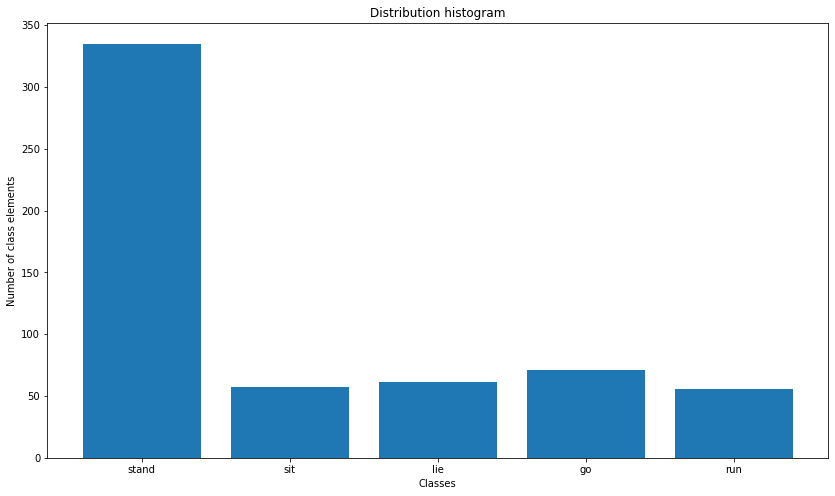

In [12]:
distrib_hist(y_train)

# LightGBM Classifier
0.4261

In [ ]:
params = {'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 10,
        'metric': 'multi_logloss',
        'learning_rate': 0.003,
        'max_depth': 10,
        'num_leaves': 20}

d_train = lgbm.Dataset(X_train, label=y_train['label'])

num_epochs = 1000

In [ ]:
lgbm_classifier = lgbm.train(params, d_train, num_epochs)

In [ ]:
y_pred = lgbm_classifier.predict(X_test)

In [ ]:
y_pred = [np.argmax(line) for line in y_pred]

In [ ]:
precision_score(y_pred, y_test['label'], average=None).mean()

0.42230411495378234

# Catboost Classifier
pure 0.6551 eval 0.9002 multiclass 69.7% test

augm 0.6724 eval 0.8873 multiclass 69.7% test

stand/not_stand 0.75 eval 0.5330 logloss 75.5% test

sit/lie/go/run 0.67 eval 0.8882 multiclass 68.7% test

##### Классификация по всем классам

In [13]:
train_pool = Pool(data=X_train, label=y_train['label'])
eval_pool = Pool(data=X_val, label=y_val['label'])

In [14]:
cat_classifier = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='Accuracy',
    use_best_model=True,
    random_state = 22
)

In [15]:
cat_classifier.fit(train_pool, eval_set=eval_pool, verbose=False, plot=False)

In [16]:
cat_classifier.get_best_score()

{'learn': {'Accuracy': 1.0, 'MultiClass': 0.027666257388178496},
 'validation': {'Accuracy': 0.6681034482758621,
  'MultiClass': 0.9191877261686288}}

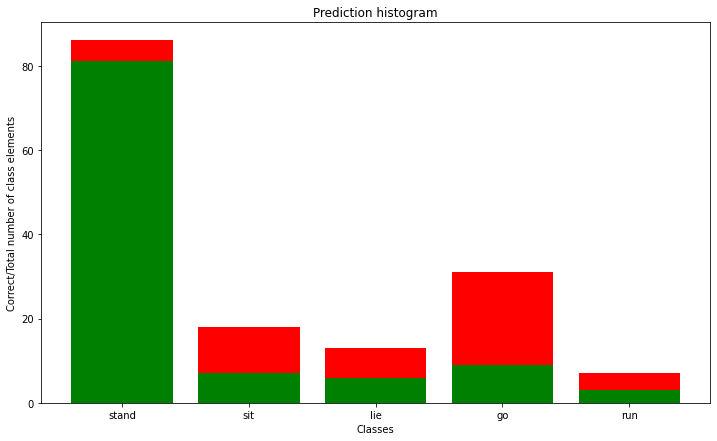


Stand:   81/86   94.2%
Sit:   7/18   38.9%
Lie:   6/13   46.2%
Go:   9/31   29.0%
Run:   3/7   42.9%

total:   106/155   68.4%


In [17]:
preds = cat_classifier.predict(X_test)
targets = list(y_test["label"])

names = list(y_train.columns)[:-1]

preds = cat_classifier.predict(X_test)
targets = list(y_test["label"])

n = len(names)

classes_count = [0] * n
classes_correct = [0] * n

for idx in range(len(targets)):
    classes_count[targets[idx]] += 1
    if targets[idx] == preds[idx]:
        classes_correct[targets[idx]] += 1

plt.rcParams['figure.figsize'] = (12, 7)
plt.bar(range(n), classes_count, color="red");
plt.bar(range(n), classes_correct, color="green");
plt.xticks(range(n), names);
plt.ylabel('Correct/Total number of class elements')
plt.xlabel('Classes')
plt.title("Prediction histogram")
plt.show()

print()
for idx in range(n):
    print("{}:   {}/{}   {:.1f}%".format(names[idx].title(), classes_correct[idx], classes_count[idx], 100*classes_correct[idx]/classes_count[idx]))

print("\ntotal:   {}/{}   {:.1f}%".format(sum(classes_correct), sum(classes_count), 100*sum(classes_correct)/sum(classes_count)))

In [18]:
cat_classifier.save_model('cat_classifier_pure5')

In [23]:
cat_classifier.save_model('cat_classifier_augm5')

##### Разбиение на 2 класса

In [12]:
train_pool = Pool(data=X_train, label=y_train['label'])
eval_pool = Pool(data=X_val, label=y_val['label']) 

In [13]:
cat_classifier1 = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='Accuracy',
    use_best_model=True,
    random_state = 22
)

In [14]:
cat_classifier1.fit(train_pool, eval_set=eval_pool, verbose=False, plot=False)

In [15]:
cat_classifier1.get_best_score()

{'learn': {'Accuracy': 1.0, 'Logloss': 0.020742122385392414},
 'validation': {'Accuracy': 0.7543103448275862, 'Logloss': 0.5213092190036279}}

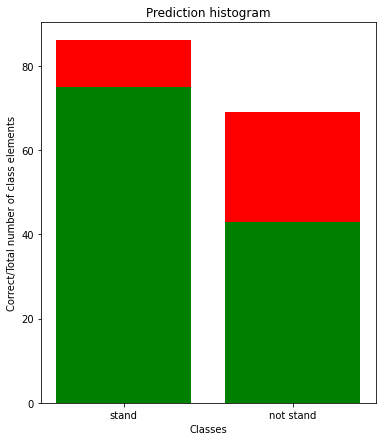


Stand:   75/86   87.2%
Not Stand:   43/69   62.3%

total:   118/155   76.1%


In [16]:
preds = cat_classifier1.predict(X_test)
targets = list(y_test["label"])

names = ['stand', 'not stand']

preds = cat_classifier1.predict(X_test)
targets = list(y_test["label"])

n = len(names)

classes_count = [0] * n
classes_correct = [0] * n

for idx in range(len(targets)):
    classes_count[targets[idx]] += 1
    if targets[idx] == preds[idx]:
        classes_correct[targets[idx]] += 1

plt.rcParams['figure.figsize'] = (6, 7)
plt.bar(range(n), classes_count, color="red");
plt.bar(range(n), classes_correct, color="green");
plt.xticks(range(n), names);
plt.ylabel('Correct/Total number of class elements')
plt.xlabel('Classes')
plt.title("Prediction histogram")
plt.show()

print()
for idx in range(n):
    print("{}:   {}/{}   {:.1f}%".format(names[idx].title(), classes_correct[idx], classes_count[idx], 100*classes_correct[idx]/classes_count[idx]))

print("\ntotal:   {}/{}   {:.1f}%".format(sum(classes_correct), sum(classes_count), 100*sum(classes_correct)/sum(classes_count)))

In [17]:
cat_classifier1.save_model('cat_classifier_stand2')

##### Разбиение оставшихся 4 классов

In [18]:
next_idx = 0

X_new = pd.DataFrame()
y_new = pd.DataFrame()

for idx in list(map(int, X.index)):
    features = list(X.loc[idx])
    answers = list(y.loc[idx])

    if answers[-1] == 1:
        X_new = X_new.append(pd.Series(features, index=X.columns, name=next_idx))
        y_new = y_new.append(pd.Series(answers, index=y.columns, name=next_idx))
        next_idx += 1

y_new.pop('stand')
X_new = X_new[X.columns]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
412    0.0
413    0.0
414    0.0
415    0.0
416    0.0
Name: stand, Length: 417, dtype: float64

In [19]:
y_new['label'] = 0

y_columns = list(y.columns)
y_columns.remove('label')
y_columns.remove('stand')

for idx in range(len(y_columns)):
    y_new['label'] += y_new[y_columns[idx]] * idx
    
y_new = y_new.astype(int)

In [23]:
X_new

,bounds_x,bounds_y,bounds_width,bounds_height,L_eye_v,L_eye_x,L_eye_y,R_eye_v,R_eye_x,R_eye_y,L_ear_v,L_ear_x,L_ear_y,R_ear_v,R_ear_x,R_ear_y,Nose_v,Nose_x,Nose_y,Throat_v,Throat_x,Throat_y,Tail_v,Tail_x,Tail_y,withers_v,withers_x,withers_y,L_F_elbow_v,L_F_elbow_x,L_F_elbow_y,R_F_elbow_v,R_F_elbow_x,R_F_elbow_y,L_B_elbow_v,L_B_elbow_x,L_B_elbow_y,R_B_elbow_v,R_B_elbow_x,R_B_elbow_y,L_F_knee_v,L_F_knee_x,L_F_knee_y,R_F_knee_v,R_F_knee_x,R_F_knee_y,L_B_knee_v,L_B_knee_x,L_B_knee_y,R_B_knee_v,R_B_knee_x,R_B_knee_y,L_F_paw_v,L_F_paw_x,L_F_paw_y,R_F_paw_v,R_F_paw_x,R_F_paw_y,L_B_paw_v,L_B_paw_x,L_B_paw_y,R_B_paw_v,R_B_paw_x,R_B_paw_y,animal
0,0.006667,0.023810,0.993333,0.995238,1.0,0.593333,0.338095,1.0,0.440000,0.309524,1.0,0.676667,0.157143,1.0,0.390000,0.090476,1.0,0.513333,0.409524,1.0,0.523333,0.566667,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.710000,0.695238,1.0,0.313333,0.619048,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.883333,0.771429,1.0,0.240000,0.752381,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.020000,0.828571,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,0.083333,0.000000,0.870000,0.977778,1.0,0.593333,0.351111,1.0,0.380000,0.440000,1.0,0.650000,0.088889,1.0,0.156667,0.213333,1.0,0.520000,0.524444,1.0,0.533333,0.728889,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,0.203333,0.115556,0.756667,0.862222,1.0,0.346667,0.355556,1.0,0.280000,0.355556,1.0,0.403333,0.182222,1.0,0.250000,0.191111,1.0,0.316667,0.422222,1.0,0.393333,0.408889,1.0,0.726667,0.737778,1.0,0.533333,0.257778,1.0,0.510000,0.533333,1.0,0.426667,0.537778,1.0,0.640000,0.715556,0.0,0.000000,0.000000,1.0,0.496667,0.684444,1.0,0.450000,0.680000,1.0,0.566667,0.782222,0.0,0.000000,0.000000,1.0,0.466667,0.791111,1.0,0.433333,0.773333,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,0.129825,0.000000,0.929825,0.993333,1.0,0.775439,0.263333,1.0,0.554386,0.310000,1.0,0.789474,0.033333,1.0,0.385965,0.116667,1.0,0.666667,0.326667,1.0,0.698246,0.496667,0.0,0.000000,0.000000,1.0,0.301754,0.333333,1.0,0.747368,0.723333,1.0,0.389474,0.690000,0.0,0.000000,0.000000,1.0,0.203509,0.630000,1.0,0.663158,0.850000,1.0,0.428070,0.820000,0.0,0.000000,0.000000,1.0,0.238596,0.756667,1.0,0.649123,0.953333,1.0,0.435088,0.903333,0.0,0.000000,0.000000,1.0,0.280702,0.846667,0.0
4,0.014423,0.013333,0.956731,0.960000,1.0,0.649038,0.230000,1.0,0.485577,0.230000,1.0,0.774038,0.070000,1.0,0.389423,0.083333,1.0,0.567308,0.293333,1.0,0.649038,0.380000,1.0,0.062500,0.830000,1.0,0.322115,0.423333,1.0,0.850962,0.613333,1.0,0.600962,0.653333,0.0,0.000000,0.000000,1.0,0.384615,0.766667,1.0,0.846154,0.780000,1.0,0.677885,0.796667,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.875000,0.856667,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,0.204687,0.000000,0.998437,0.828413,1.0,0.337500,0.584871,0.0,0.000000,0.000000,1.0,0.384375,0.507380,0.0,0.000000,0.000000,1.0,0.250000,0.798893,1.0,0.578125,0.431734,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.812500,0.306273,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.798438,0.533210,1.0,0.520312,0.562731,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.818750,0.706642,1.0,0.462500,0.728782,0.0,0.000000,0.000000,0.0,0.000000,0.000000,4.0
413,0.332813,0.227700,0.817187,0.936620,1.0,0.456250,0.321596,1.0,0.385937,0.319249,1.0,0.475000,0.291080,1.0,0.371875,0.272300,1.0,0.414062,0.380282,1.0,0.412500,0.535211,1.0,0.775000,0.399061,1.0,

In [24]:
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, test_size=0.4, random_state=22)
X_new_val, X_new_test, y_new_val, y_new_test = train_test_split(X_new_test, y_new_test, test_size=0.4, random_state=22)

print(f"SPLIT\nTrain:\t{len(X_new_train)}\nVal:\t{len(X_new_val)}\nTest:\t{len(X_new_test)}")

SPLIT
Train:	250
Val:	100
Test:	67


In [25]:
train_pool = Pool(data=X_new_train, label=y_new_train['label'])
eval_pool = Pool(data=X_new_val, label=y_new_val['label']) 

In [26]:
cat_classifier2 = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='Accuracy',
    use_best_model=True,
    random_state = 22
)

In [27]:
cat_classifier2.fit(train_pool, eval_set=eval_pool, verbose=False, plot=False)

In [28]:
cat_classifier2.get_best_score()

{'learn': {'Accuracy': 1.0, 'MultiClass': 0.014061682248007985},
 'validation': {'Accuracy': 0.65, 'MultiClass': 0.9008209458820332}}

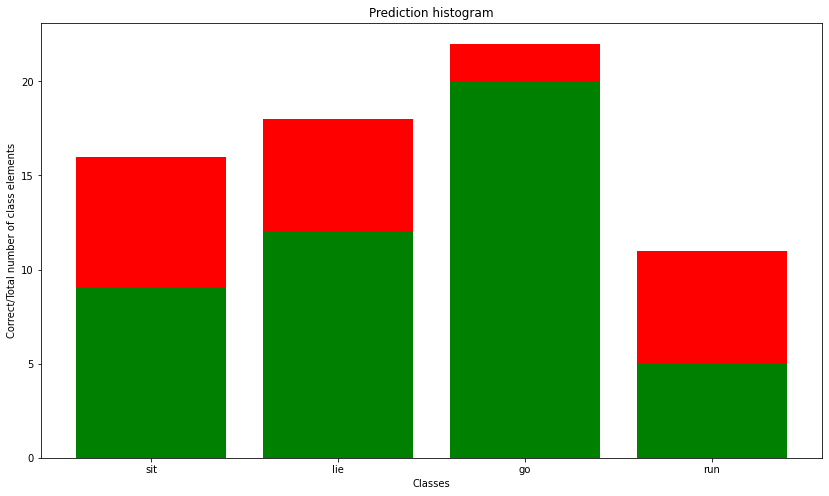


Sit:   9/16   56.2%
Lie:   12/18   66.7%
Go:   20/22   90.9%
Run:   5/11   45.5%

total:   46/67   68.7%


In [29]:
preds = cat_classifier2.predict(X_new_test)
targets = list(y_new_test["label"])

names = y_columns

preds = cat_classifier2.predict(X_new_test)
targets = list(y_new_test["label"])

n = len(names)

classes_count = [0] * n
classes_correct = [0] * n

for idx in range(len(targets)):
    classes_count[targets[idx]] += 1
    if targets[idx] == preds[idx]:
        classes_correct[targets[idx]] += 1

plt.rcParams['figure.figsize'] = (14, 8)
plt.bar(range(n), classes_count, color="red");
plt.bar(range(n), classes_correct, color="green");
plt.xticks(range(n), names);
plt.ylabel('Correct/Total number of class elements')
plt.xlabel('Classes')
plt.title("Prediction histogram")
plt.show()

print()
for idx in range(n):
    print("{}:   {}/{}   {:.1f}%".format(names[idx].title(), classes_correct[idx], classes_count[idx], 100*classes_correct[idx]/classes_count[idx]))

print("\ntotal:   {}/{}   {:.1f}%".format(sum(classes_correct), sum(classes_count), 100*sum(classes_correct)/sum(classes_count)))

In [30]:
cat_classifier2.save_model('cat_classifier_last4')

# MyNet
0.6341

In [ ]:
class AnimalsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_idx = self.data.iloc[idx, 0]
        img_name = os.path.join(self.root_dir, "0"*(3-len(str(img_idx))) + str(img_idx) + ".jpeg")
        image = Image.open(img_name)
        features = self.data.iloc[idx, 1:].to_numpy()

        if self.transform:
            image = self.transform(image)

        sample = (image, features)

        return sample

In [ ]:
target_size = (188, 188)

In [ ]:
train_transforms = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
])


for column in df.columns:
    if '_x' in column or '_width' in column or '_y' in column or '_height' in column:
        df[column] = df[column].astype(float)

df_dict = df.to_dict()

for idx in df_dict['id'].values():
    img_name = os.path.join(data_dir, 'animals', "0"*(3-len(str(idx))) + str(idx) + ".jpeg")
    image = Image.open(img_name)
    x_size, y_size = image.size
    for column in df_dict.keys():
        if '_x' in column or '_width' in column:
            df_dict[column][idx] /= x_size
        elif '_y' in column or '_height' in column:
            df_dict[column][idx] /= y_size

df = pd.DataFrame.from_dict(df_dict)

dataset = AnimalsDataset(csv_file=df, root_dir=os.path.join(data_dir, 'animals'), transform=train_transforms)

print(f"Экземпляров в датасете: {len(dataset)}")

Экземпляров в датасете: 967


In [ ]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [580, 232, 155])

batch_size = 20
num_workers = 0

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [ ]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.conv1_1 = nn.Conv2d(10, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=3)
        self.conv4 = nn.Conv2d(20, 30, kernel_size=3)

        self.fc1 = nn.Linear(1280, 640)
        self.fc2 = nn.Linear(640, 300)
        self.fc3 = nn.Linear(300, 100)
        self.fc4 = nn.Linear(100, 31)

        self.fc5 = nn.Linear(100, 60)
        self.fc6 = nn.Linear(60, 30)
        self.fc7 = nn.Linear(30, 20)
        self.fc8 = nn.Linear(20, 9)

        self.dropout = nn.Dropout2d()
        self.bn21 = nn.BatchNorm2d(10)
        self.bn22 = nn.BatchNorm2d(20)
        self.bn11 = nn.BatchNorm1d(60)
        self.bn12 = nn.BatchNorm1d(30)
        self.bn13 = nn.BatchNorm1d(20)


    
    def forward(self, x, x1):
        # input is 256x256x3
        # conv1(kernel=3, filters=10)x2 188x188x3 -> 184x184x10
        # max_pool(kernel=2) 184x184x10 -> 92x92x10
        x = F.relu(self.bn21(F.max_pool2d(self.conv1_1(self.conv1(x)), 2)))
        
        # conv2(kernel=3, filters=20)x2 92x92x10 -> 88x88x20
        # max_pool(kernel=2) 88x88x20 -> 44x44x20
        x = F.relu(self.bn22(F.max_pool2d(self.dropout(self.conv3(self.conv2(x))), 2)))

        # conv2(kernel=3, filters=20)x2 44x44x20 -> 40x40x20
        # max_pool(kernel=2) 40x40x20 -> 20x20x20
        x = F.relu(self.bn22(F.max_pool2d(self.dropout(self.conv3(self.conv3(x))), 2)))

        # conv2(kernel=3, filters=20)x2 20x20x20 -> 16x16x20
        # max_pool(kernel=2) 16x16x20 -> 8x8x20
        x = F.relu(self.bn22(F.max_pool2d(self.dropout(self.conv3(self.conv3(x))), 2)))
        
        # flatten 8x8x20 = 1280
        x = x.view(-1, 1280)
        
        # 1280 -> 640
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)

        # 640 -> 300
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)

        # 300 -> 100
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        
        # 100 -> 31
        x = F.softmax(self.fc4(x))
        
        # 31 + 69 = 100
        x = torch.cat((x, x1.float()), dim=1)

        # 100 -> 60
        x = F.relu(self.bn11(self.fc5(x)))
        x = F.dropout(x, training=self.training)

        # 60 -> 30
        x = F.relu(self.bn12(self.fc6(x)))
        x = F.dropout(x, training=self.training)

        # 30 -> 20
        x = F.relu(self.bn13(self.fc7(x)))
        x = F.dropout(x, training=self.training)

        # 20 -> 9
        x = self.fc8(x)

        return F.log_softmax(x)

In [ ]:
model = MyNet()
model.to(device)

criterion = nn.NLLLoss()

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, amsgrad=True, lr=0.001)

loss_history = {'train':[], 'val':[]}
acc_history = []

In [ ]:
def train():
    model.train()

    running_loss = 0.
    for images, targets in train_dataloader:
        images = images.to(device)
        targets = targets.to(device)
        x1, answers = targets[:, :-9], torch.max(targets[:, -9:], 1)[1]

        images = Variable(images)
        x1 = Variable(x1)
        answers = Variable(answers)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            preds = model(images, x1)

            loss = criterion(preds, answers)
            loss.backward()
            running_loss += loss.item() / len(images)

            optimizer.step()

    epoch_loss = running_loss/len(train_dataloader)
    loss_history['train'].append(epoch_loss)
    print('TRAIN Average loss: {:.4f}'.format(epoch_loss))

In [ ]:
def val():
    model.eval()

    running_loss = 0.
    correct = 0
    for images, targets in val_dataloader:
        images = images.to(device)
        targets = targets.to(device)
        x1, answers = targets[:, :-9], torch.max(targets[:, -9:], 1)[1]

        images = Variable(images)
        x1 = Variable(x1)
        answers = Variable(answers)
        
        with torch.no_grad():
            preds = model(images, x1)
            loss = criterion(preds, answers)
            running_loss += loss.item() / len(images)

            pred = torch.max(preds.data, 1)[1]
            correct += pred.eq(answers.data).cpu().sum() / len(images)


    epoch_loss = running_loss/len(val_dataloader)
    loss_history['val'].append(epoch_loss)
    accuracy = correct / len(val_dataloader)
    acc_history.append(accuracy)
    print('EVAL  Average loss: {:.4f}, Accuracy: {:.4f}\n'.format(epoch_loss, accuracy))

In [ ]:
num_epochs = 15

for epoch in range(num_epochs):
    print("Epoch %d" % epoch)
    train()
    val()

Epoch 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


TRAIN Average loss: 0.1136
EVAL  Average loss: 0.1141, Accuracy: 0.0611

Epoch 1
TRAIN Average loss: 0.1048
EVAL  Average loss: 0.1064, Accuracy: 0.2958

Epoch 2
TRAIN Average loss: 0.0971
EVAL  Average loss: 0.1006, Accuracy: 0.4403

Epoch 3
TRAIN Average loss: 0.0922
EVAL  Average loss: 0.0972, Accuracy: 0.4583

Epoch 4
TRAIN Average loss: 0.0888
EVAL  Average loss: 0.0924, Accuracy: 0.5292

Epoch 5
TRAIN Average loss: 0.0846
EVAL  Average loss: 0.0901, Accuracy: 0.5708

Epoch 6
TRAIN Average loss: 0.0832
EVAL  Average loss: 0.0851, Accuracy: 0.5833

Epoch 7
TRAIN Average loss: 0.0814
EVAL  Average loss: 0.0832, Accuracy: 0.5806

Epoch 8
TRAIN Average loss: 0.0812
EVAL  Average loss: 0.0832, Accuracy: 0.5722

Epoch 9
TRAIN Average loss: 0.0769
EVAL  Average loss: 0.0802, Accuracy: 0.5778

Epoch 10
TRAIN Average loss: 0.0779
EVAL  Average loss: 0.0752, Accuracy: 0.5833

Epoch 11
TRAIN Average loss: 0.0787
EVAL  Average loss: 0.0767, Accuracy: 0.5750

Epoch 12
TRAIN Average loss: 0.076

Best loss train: 0.0745
Best loss eval: 0.0729


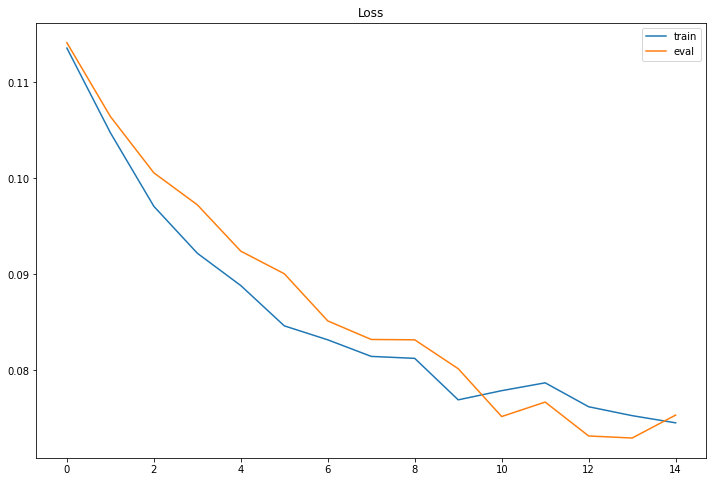


Best acc: 0.5972


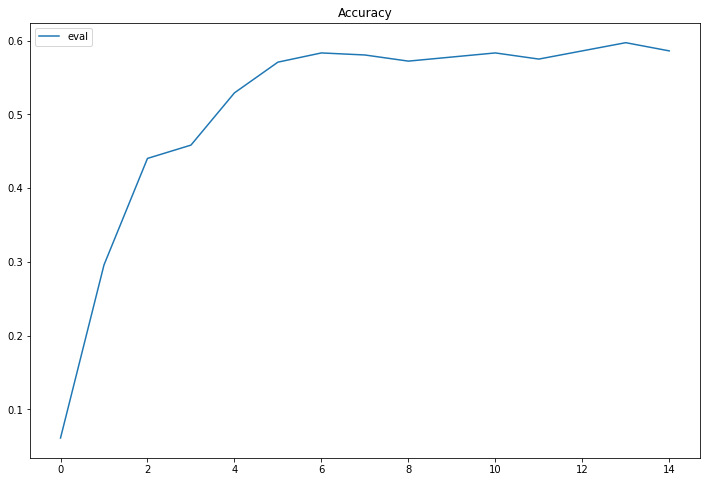

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.plot(loss_history['train'], label='train')
plt.plot(loss_history['val'], label='eval')
plt.legend()
plt.title('Loss');
print('Best loss train: {:.4f}'.format(min(loss_history['train'])))
print('Best loss eval: {:.4f}'.format(min(loss_history['val'])))
plt.show()

print()

plt.plot(acc_history, label='eval')
plt.legend()
plt.title('Accuracy');
print('Best acc: {:.4f}'.format(max(acc_history)))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


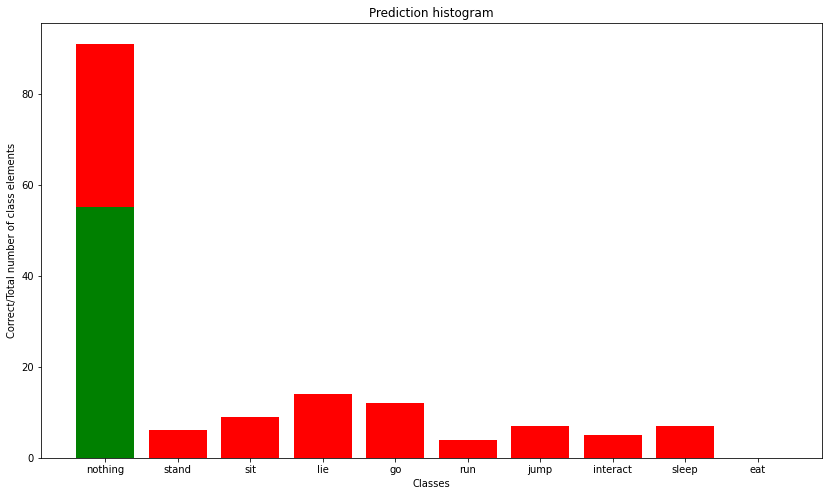


Nothing:   55/91   60.4%
Stand:   0/6   0.0%
Sit:   0/9   0.0%
Lie:   0/14   0.0%
Go:   0/12   0.0%
Run:   0/4   0.0%
Jump:   0/7   0.0%
Interact:   0/5   0.0%
Sleep:   0/7   0.0%
Eat:   0/0

total:   55/155   35.5%


In [ ]:
model.eval()

classes_count = [0] * 10
classes_correct = [0] * 10

for images, targets in test_dataloader:
    images = images.to(device)
    targets = targets.to(device)
    x1, answers = targets[:, :-9], torch.max(targets[:, -9:], 1)[1]

    images = Variable(images)
    x1 = Variable(x1)
    answers = Variable(answers)
    
    with torch.no_grad():
        preds = model(images, x1)

        preds = preds.cpu()
        pred_max = torch.exp(torch.max(preds.data, 1)[0]).tolist()
        pred_class = (torch.max(preds.data, 1)[1]+1).tolist()
        answers = answers.tolist()

        for idx in range(len(pred_class)):
            if pred_max[idx] < 0.5:
                pred_class[idx] = 0

            classes_count[answers[idx]] += 1
            if answers[idx] == pred_class[idx]:
                classes_correct[answers[idx]] += 1

plt.rcParams['figure.figsize'] = (14, 8)
plt.bar(range(10), classes_count, color="red");
plt.bar(range(10), classes_correct, color="green");
plt.xticks(range(10), names);
plt.ylabel('Correct/Total number of class elements')
plt.xlabel('Classes')
plt.title("Prediction histogram")
plt.show()

print()
for idx in range(10):
    if classes_count[idx] != 0:
        print("{}:   {}/{}   {:.1f}%".format(names[idx].title(), classes_correct[idx], classes_count[idx], 100*classes_correct[idx]/classes_count[idx]))
    else:
        print("{}:   {}/{}".format(names[idx].title(), classes_correct[idx], classes_count[idx]))

print("\ntotal:   {}/{}   {:.1f}%".format(sum(classes_correct), sum(classes_count), 100*sum(classes_correct)/sum(classes_count)))